In [23]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import (
    col, count, countDistinct, when, to_timestamp, hour, dayofmonth, date_format, avg, min, max, lit, round,
    split, dayofweek, max as spark_max, when
)
from pyspark.sql.window import Window

In [10]:
spark = SparkSession.builder \
    .appName("EcommerceAnalysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

26/01/24 15:17:34 WARN Utils: Your hostname, onizuka-Latitude-5500 resolves to a loopback address: 127.0.1.1; using 192.168.11.234 instead (on interface wlo1)
26/01/24 15:17:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/24 15:17:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# 1. Chargement du dataset nettoyé
output_path = "data_clean/gold_ecommerce_cleaned"
df_gold_gold_gold = spark.read.parquet(output_path)

In [14]:
event_dist = df_gold.groupBy("event_type").count().orderBy(col("count").desc())
event_dist.show()

total_events = df_gold.count()
purchase_rate = (
    event_dist.filter(col("event_type") == "purchase").select("count").collect()[0][0] / total_events
)
print(f"Purchase event share: {purchase_rate * 100:.2f}%")



+----------+---------+
|event_type|    count|
+----------+---------+
|      view|104331840|
|      cart|  3828461|
|  purchase|  1659703|
+----------+---------+

Purchase event share: 1.51%


1. Data Imbalance : Avec seulement 1,51 % d'achats, les données sont fortement déséquilibrées. Cela signifie qu'un modèle de prédiction simple pourrait être biaisé vers l'action "view".
2. Le faible nombre d'achats confirme que nous ne pouvons pas entraîner l'IA uniquement sur les ventes. Nous devons utiliser les vues et les ajouts au panier comme signaux de préférence "implicites" pour enrichir le modèle. 

/tmp/ipykernel_12671/50974530.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Nombre', y='Étape', data=df_viz, palette='viridis')


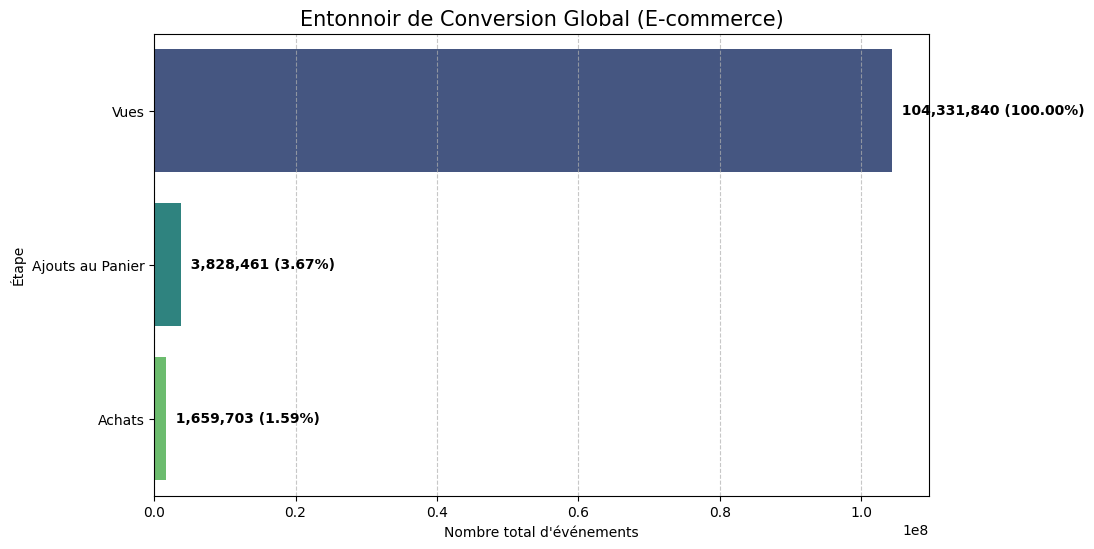

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'Étape': ['Vues', 'Ajouts au Panier', 'Achats'],
    'Nombre': [104331840, 3828461, 1659703]
}

df_viz = pd.DataFrame(data)

# 2. Création du graphique
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Nombre', y='Étape', data=df_viz, palette='viridis')

# 3. Ajout des pourcentages de conversion sur le graphique
total = df_viz['Nombre'][0]
for i, valor in enumerate(df_viz['Nombre']):
    pct = (valor / total) * 100
    plt.text(valor, i, f'  {valor:,} ({pct:.2f}%)', va='center', fontweight='bold')

plt.title('Entonnoir de Conversion Global (E-commerce)', fontsize=15)
plt.xlabel('Nombre total d\'événements')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

1. cette viz  montre que l'achat est un événement rare.
alors si je crées un système de recommandation basé uniquement sur les achats (Explicit Feedback), je vais ignorer 98,5% des données

In [19]:
print("Number of users, products and categories")
agg_counts = df_gold.agg(
    countDistinct("user_id").alias("Total_users"),
    countDistinct("product_id").alias("Total_products"),
    countDistinct("category_id").alias("Total_categories")
)
agg_counts.show()


Number of users, products and categories


+-----------+--------------+----------------+
|Total_users|Total_products|Total_categories|
+-----------+--------------+----------------+
|    5316649|        206876|             691|
+-----------+--------------+----------------+



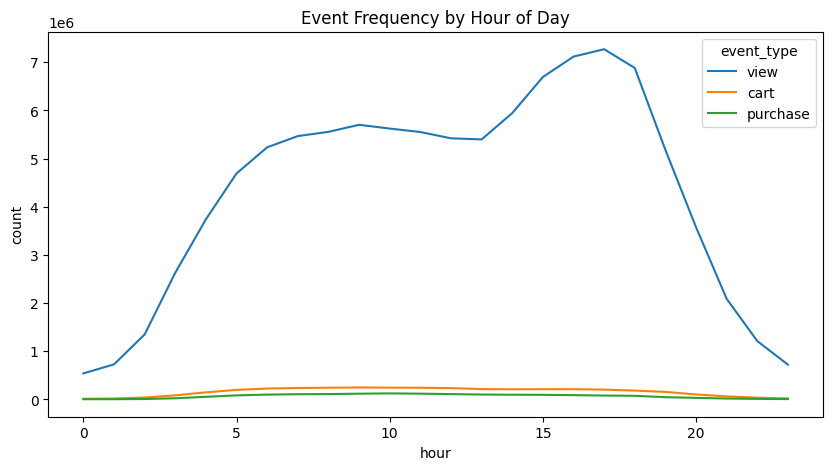

In [20]:
df_gold = df_gold.withColumn("date", date_format(col("event_time"), "yyyy-MM-dd"))
df_gold = df_gold.withColumn("hour", hour(col("event_time")))

hourly_df = df_gold.groupBy("hour", "event_type").count().orderBy("hour")

# Convert to Pandas for visualization
pdf_hourly = hourly_df.toPandas()
plt.figure(figsize=(10, 5))
sns.lineplot(data=pdf_hourly, x="hour", y="count", hue="event_type")
plt.title("Event Frequency by Hour of Day")
plt.show()


1. Le trafic bouge, mais pas l'achat : Même si le nombre de visiteurs (vues) explose le nombre d'achats reste très faible et constant toute la journée.

2. L'heure n'influence pas vraiment la décision d'achat. Cela confirme que l'achat est un acte rare et réfléchi, ce qui rend l'utilisation d'un algorithme de recommandation encore plus importante pour "pousser" l'utilisateur vers le panier.

In [26]:
product_stats = (
    df_gold.groupBy("brand")
      .agg(
          count(when(col("event_type") == "view", True)).alias("n_views"),
          count(when(col("event_type") == "purchase", True)).alias("n_purchases"),
          count(when(col("event_type") == "cart", True)).alias("n_carts")
      )
      .filter(col("n_views") > 0)
      .withColumn("conversion_rate_purchase", round((col("n_purchases") / col("n_views")) * 100, 2))
      .withColumn("conversion_rate_cart", round((col("n_carts") / col("n_views")) * 100, 2))
      
)

print("Top 10 Converting brand (View ➜ Purchase)")
product_stats.orderBy(col("conversion_rate_purchase").desc()).limit(10).show()
print("Top 10 Converting brand (View ➜ Cart)")
product_stats.orderBy(col("conversion_rate_cart").desc()).limit(10).show()


Top 10 Converting brand (View ➜ Purchase)


+--------------+-------+-----------+-------+------------------------+--------------------+
|         brand|n_views|n_purchases|n_carts|conversion_rate_purchase|conversion_rate_cart|
+--------------+-------+-----------+-------+------------------------+--------------------+
|        dotemu|      2|          1|      0|                    50.0|                 0.0|
|           htl|      5|          1|      1|                    20.0|                20.0|
|   pixiebelles|      5|          1|      2|                    20.0|                40.0|
|        casela|     28|          4|      0|                   14.29|                 0.0|
|prajm-evroznak|      8|          1|      1|                    12.5|                12.5|
|      yoshioki|     54|          6|     10|                   11.11|               18.52|
|        yokito|     45|          5|      7|                   11.11|               15.56|
|         lamel|      9|          1|      2|                   11.11|               22.22|

+------------+-------+-----------+-------+------------------------+--------------------+
|       brand|n_views|n_purchases|n_carts|conversion_rate_purchase|conversion_rate_cart|
+------------+-------+-----------+-------+------------------------+--------------------+
| pixiebelles|      5|          1|      2|                    20.0|                40.0|
|   bigklever|      4|          0|      1|                     0.0|                25.0|
|       lamel|      9|          1|      2|                   11.11|               22.22|
|merejbaspasy|     91|          3|     19|                     3.3|               20.88|
|         htl|      5|          1|      1|                    20.0|                20.0|
|    autolite|      5|          0|      1|                     0.0|                20.0|
|    yoshioki|     54|          6|     10|                   11.11|               18.52|
|      kursiv|     11|          1|      2|                    9.09|               18.18|
|        maja|     11

On remarque que les taux de conversion les plus élevés appartiennent à des marques avec un très faible volume de vues.

In [27]:
purchase = df_gold.filter(col("event_type") == 'purchase')
purchase = purchase.dropna()
print("Top 10 brands purchased by customer:")
purchase.groupBy('brand').agg(
        count(col('event_type')).alias('No_of_purchases')
    ).orderBy(col('No_of_purchases').desc()).limit(10).show()
print("Top 10 categories purchased by customer:")
purchase.groupBy('category_code').agg(
        count(col('event_type')).alias('No_of_purchases')
    ).orderBy(col('No_of_purchases').desc()).limit(10).show()


Top 10 brands purchased by customer:


+-------+---------------+
|  brand|No_of_purchases|
+-------+---------------+
|samsung|         370357|
|  apple|         308243|
| xiaomi|         104496|
| huawei|          46758|
|   oppo|          25967|
|     lg|          19657|
|   acer|          13282|
|  artel|          11984|
| lenovo|          11124|
|indesit|          10210|
+-------+---------------+

Top 10 categories purchased by customer:


+--------------------+---------------+
|       category_code|No_of_purchases|
+--------------------+---------------+
|electronics.smart...|         720027|
|electronics.audio...|          71179|
|electronics.video.tv|          51721|
|  electronics.clocks|          38070|
|appliances.kitche...|          35736|
|  computers.notebook|          33868|
|appliances.enviro...|          30340|
|appliances.kitche...|          19291|
|       apparel.shoes|          12166|
|  electronics.tablet|          11721|
+--------------------+---------------+



26/01/24 15:39:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/24 15:39:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/24 15:39:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/24 15:39:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/24 15:39:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/24 15:39:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/24 1

Nombre de produits total vendus : 68076
Nombre de produits réalisant 80% des ventes : 3763
Ratio : 5.53% du catalogue fait 80% du chiffre d'affaires.


26/01/24 15:39:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/24 15:39:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/24 15:39:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/24 15:39:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/24 15:39:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/24 15:39:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/24 1

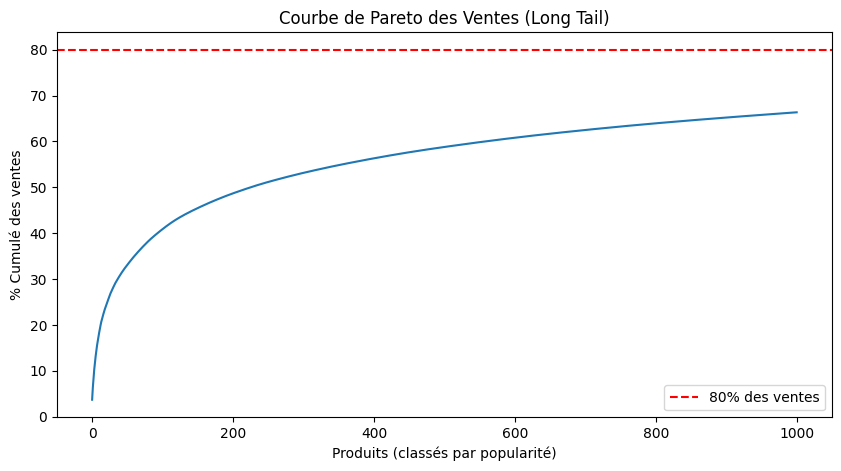

In [24]:
# 1. Calculer le nombre de ventes par produit
product_sales = df_gold.filter(F.col("event_type") == "purchase") \
    .groupBy("product_id") \
    .agg(F.count("*").alias("sales_count")) \
    .orderBy(F.col("sales_count").desc())

# 2. Utiliser une Window Function pour calculer le pourcentage cumulé
window_spec = Window.orderBy(F.col("sales_count").desc()) \
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

total_sales = product_sales.agg(F.sum("sales_count")).collect()[0][0]

long_tail_df = product_sales.withColumn("cum_sales", F.sum("sales_count").over(window_spec)) \
    .withColumn("cum_perc", (F.col("cum_sales") / total_sales) * 100)

# 3. Analyser les "Best-Sellers" (le top qui fait 80% des ventes)
top_80_percent = long_tail_df.filter(F.col("cum_perc") <= 80)
nb_top_products = top_80_percent.count()
total_products = product_sales.count()

print(f"Nombre de produits total vendus : {total_products}")
print(f"Nombre de produits réalisant 80% des ventes : {nb_top_products}")
print(f"Ratio : {(nb_top_products / total_products) * 100:.2f}% du catalogue fait 80% du chiffre d'affaires.")

# 4. Visualisation de la courbe de Pareto
pdf_tail = long_tail_df.limit(1000).toPandas() # On prend le top 1000 pour la viz
plt.figure(figsize=(10, 5))
plt.plot(range(len(pdf_tail)), pdf_tail['cum_perc'])
plt.axhline(y=80, color='r', linestyle='--', label='80% des ventes')
plt.title("Courbe de Pareto des Ventes (Long Tail)")
plt.xlabel("Produits (classés par popularité)")
plt.ylabel("% Cumulé des ventes")
plt.legend()
plt.show()

1. La Courbe de Pareto : alors la courbe de pareto montre que la courbe(bleu) atteigne les 80% très rapidement (avec seulement 5,53% des produits)
2. sela peut poser un  proleme que l'agent peut etre paresseux , il va proposer seuelemnt (top sellers )
3. L'objectif : Un bon système de recommandation ne doit pas être un simple panneau "Meilleures ventes". Il doit être capable de fouiller dans les 95% restants pour trouver le produit précis qui plaira à un utilisateur préc

## COLD START

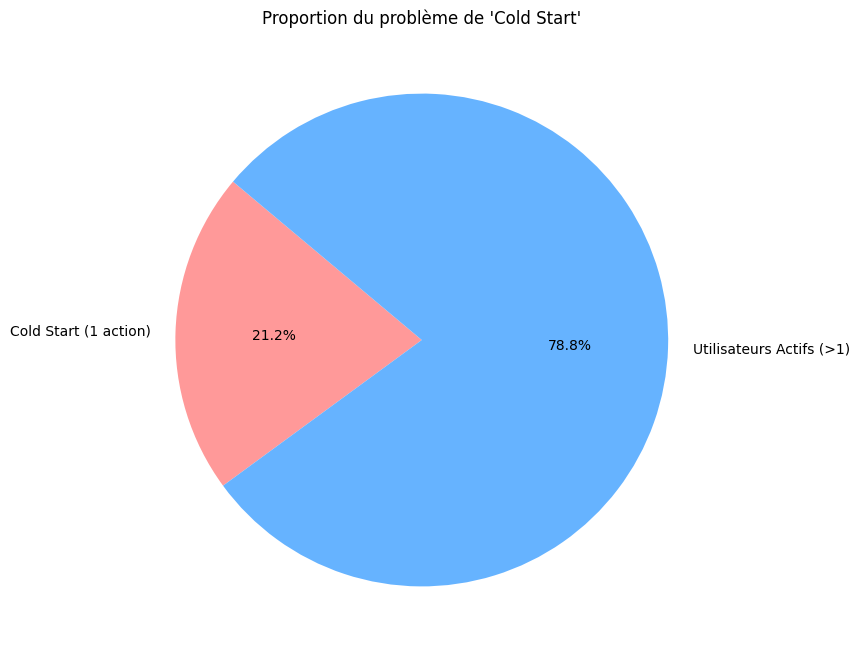

Nombre d'utilisateurs en Cold Start : 1126028


In [25]:
# 1. Calculer le nombre d'actions par utilisateur
user_activity = df_gold.groupBy("user_id").count()

# 2. Définir le seuil (Threshold)
# Un utilisateur avec 1 seule action est considéré en "Cold Start" total
cold_start_threshold = 1
cold_start_users = user_activity.filter(F.col("count") <= cold_start_threshold).count()
total_users_count = user_activity.count()

# 3. Préparation des données pour la Viz
labels = ['Cold Start (1 action)', 'Utilisateurs Actifs (>1)']
sizes = [cold_start_users, total_users_count - cold_start_users]

# 4. Visualisation (Pie Chart)
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title("Proportion du problème de 'Cold Start'")
plt.show()

print(f"Nombre d'utilisateurs en Cold Start : {cold_start_users}")

1. le Cold Start (Démarrage à froid) désigne les utilisateurs qui n'ont effectué qu'une seule action (une vue, un ajout au panier ou un achat)
2. Le Bleu (78,8 %) - Utilisateurs Actifs : C'est ta "zone de confort". Ces utilisateurs ont fait au moins 2 actions.  IA peut apprendre de leurs comportements et trouver des motifs.
3. Le Rouge (21,2 %) - Cold Start : C'est ta "zone de risque". Un utilisateur sur cinq est un parfait inconnu pour l'algorithme. C'est un chiffre assez élevé qui montre que le site attire beaucoup de nouveaux visiteurs ou de gens "de passage".

comme solution: 
4. Décider d'afficher les "Top Ventes" (ton Pareto) à ces 21 % d'utilisateurs au lieu d'une recommandation vide.
